In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import os
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt


In [2]:
from google.colab import userdata
wandb_key = userdata.get('wandb')
wandb.login(key=wandb_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# 1. Setup and preprocessing

In [48]:
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.texts = texts.reset_index(drop=True)

        # Create label encoder if not already encoded
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# 2. Model Architecture

In [49]:
class BiLSTMAttentionBERT(nn.Module):
    def __init__(self,
                 hidden_dim=256,
                 num_classes=22,  # Based on the label distribution
                 num_layers=2,    # Multiple LSTM layers
                 dropout=0.1):
        super().__init__()

        # Load BioBERT instead of BERT
        self.bert_model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
        bert_dim = self.bert_model.config.hidden_size  # Still 768 for BioBERT basee
        # Dropout for BERT outputs
        self.dropout_bert = nn.Dropout(dropout)
        # Multi-layer BiLSTM
        self.lstm = nn.LSTM(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Multi-head attention
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,  # *2 for bidirectional
            num_heads=1,
            dropout=dropout,
            batch_first=True
        )

        # Regularization layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout + 0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # BERT encoding
        bert_output = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        sequence_output = self.dropout_bert(bert_output.last_hidden_state)

        # BiLSTM processing
        lstm_out, _ = self.lstm(sequence_output)
        lstm_out = self.layer_norm(lstm_out)

        # Self-attention
        attn_out, _ = self.attention(
            query=lstm_out,
            key=lstm_out,
            value=lstm_out,
            need_weights=False
        )

        # Pooling and normalization
        pooled = torch.mean(attn_out, dim=1)
        pooled = self.batch_norm(pooled)
        pooled = self.dropout2(pooled)

        # Classification
        return self.classifier(pooled)

# 3. Training Setup

In [50]:
def load_data():
    # Define file paths
    data_files = [
        '/content/combined_labeled_sentences.csv',
        '/content/combined_new_labeled_sentences.csv',
        '/content/combined_sentence_types.csv',
    ]

    # Load and combine all files
    dfs = []
    for file in data_files:
        try:
            df = pd.read_csv(file)
            print(f"Loaded {file}: {len(df)} rows")
            dfs.append(df)
        except FileNotFoundError:
            print(f"Warning: File {file} not found")

    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)

    # Remove duplicates if any
    combined_df = combined_df.drop_duplicates(subset=['Sentence'])

    print(f"Total combined dataset size: {len(combined_df)}")
    return combined_df


In [51]:

def create_data_loaders(df, batch_size=64, tokenizer=None):
    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
    # Split data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = SentenceDataset(train_df['Sentence'], train_df['Label'], tokenizer)
    val_dataset = SentenceDataset(val_df['Sentence'], val_df['Label'], tokenizer)

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader


In [52]:

def train_model(num_epochs=1, learning_rate=2e-5, weight_decay=0.1, device=None):
    """Training function for BiLSTM model with BERT embeddings."""

    # Initialize components
    tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
    df = load_data()

    # Data augmentation
    # augmented_df = apply_augmentation(df)
    # train_loader, val_loader = create_data_loaders(augmented_df, tokenizer=tokenizer)

    train_loader, val_loader = create_data_loaders(df, tokenizer=tokenizer)

    # Label encoding
    label_encoder = LabelEncoder()
    labels = df['Label'].values
    label_encoder.fit(labels)

    # Model initialization
    model = BiLSTMAttentionBERT(
        hidden_dim=128,
        num_classes=len(label_encoder.classes_),
        num_layers=2,
        dropout=0.1
    )

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training setup
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        verbose=True
    )

    # Loss with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Early stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    # Training tracking
    best_val_acc = 0
    grad_accumulation_steps = 2
    wandb.init(
    project="bilstm-classification",
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs
        }
    )

    wandb.config.update({

        # Dataset Stats
        "train_size": len(train_loader.dataset),
        "val_size": len(val_loader.dataset),
        "num_classes": len(label_encoder.classes_),

        # Training Config
        "optimizer": optimizer.__class__.__name__,
        "scheduler": scheduler.__class__.__name__ if scheduler else "none",
    })

    # At the start of training
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()

        # Training phase
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Gradient accumulation
            loss = loss / grad_accumulation_steps
            loss.backward()

            # Gradient clipping
            if (batch_idx + 1) % grad_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * grad_accumulation_steps

            # Inside training loop, after computing loss
            train_pred = torch.argmax(outputs, dim=1)
            train_acc = (train_pred == labels).float().mean().item() * 100 # Convert to Python number

        # Validation phase
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_acc)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_best_model(
                model=model,
                optimizer=optimizer,
                epoch=epoch,
                val_acc=val_acc,
                filename=f'models/model_epoch{epoch}_acc{val_acc:.2f}.pt',
                label_encoder=label_encoder
            )

        # After each epoch
        train_loss = total_loss/len(train_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc) # Now appending a Python number
        val_accuracies.append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc) # Convert to Python number if necessary

        # Print epoch stats
        print_and_handle_metrics(
            epoch=epoch,
            num_epochs=num_epochs,
            train_loss=total_loss/len(train_loader),
            train_acc=train_acc,
            val_loss=val_loss,
            val_acc=val_acc,
            best_val_acc=best_val_acc,
            early_stopping_patience=early_stopping.patience
        )
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy_pct": train_acc,
            "val_accuracy_pct": val_acc,
            "loss_gap": train_loss - val_loss,
            "accuracy_gap": train_acc - val_acc,
            "learning_rate": optimizer.param_groups[0]["lr"]
        }, step=epoch)

        # Plot learning curves
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')

        plt.subplot(1,2,2)
        plt.plot(train_accuracies, label='Train Acc')
        plt.plot(val_accuracies, label='Val Acc')
        plt.legend()
        plt.title('Accuracy Curves')
        wandb.log({"learning_curves": wandb.Image(plt)})

    wandb.finish()
    return model, train_loader, val_loader, best_val_acc


# 4. Training function

In [53]:

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        try:
            outputs = model(input_ids, attention_mask)
        except RuntimeError as e:
            print(f"Error during forward pass: {e}")
            return None, None
        loss = criterion(outputs, labels)

        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), 100 * correct / total


In [54]:

def evaluate(model, val_loader, criterion, device):
    """
    Evaluate model performance on validation set.

    Args:
        model: The PyTorch model to evaluate
        val_loader: DataLoader for validation data
        criterion: Loss function
        device: Device to run evaluation on (cuda/cpu)

    Returns:
        tuple: (average loss, accuracy percentage)
    """
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(val_loader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Store batch results
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * np.mean(np.array(predictions) == np.array(true_labels))
    avg_loss = total_loss / len(val_loader)

    print(classification_report(true_labels, predictions))


    return avg_loss, accuracy


# Early stopping implementation

In [55]:

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [56]:


def print_and_handle_metrics(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc, best_val_acc, early_stopping_patience):
    """
    Print training metrics and return updated best validation accuracy.
    """
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')
    #print(f'Early Stopping Patience Remaining: {early_stopping_patience-no_improve_count}')


In [57]:

def save_best_model(model, optimizer, epoch, val_acc, filename, label_encoder):
    """
    Save the model checkpoint with relevant training information.

    Args:
        model: The PyTorch model to save
        optimizer: The optimizer used for training
        epoch: Current epoch number
        val_acc: Validation accuracy
        filename: Path where to save the model
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"Saving model with {len(label_encoder.classes_)} classes")
    print("Classes:", label_encoder.classes_)
    tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
    tokenizer.save_pretrained(os.path.join('models', 'tokenizer'))

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'val_acc': val_acc,
        'label_encoder_classes': label_encoder.classes_,
        'num_classes': len(label_encoder.classes_)
    }, filename, _use_new_zipfile_serialization=True)


In [58]:

def load_saved_model(model, optimizer, filename):
    """
    Load a saved model checkpoint.

    Args:
        model: The model architecture to load weights into
        optimizer: The optimizer to load state into
        filename: Path to the saved model checkpoint

    Returns:
        model: Loaded model
        optimizer: Loaded optimizer
        epoch: The epoch where training stopped
        val_acc: The validation accuracy at save time
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_acc = checkpoint['val_acc']
    return model, optimizer, epoch, val_acc



Loaded /content/combined_labeled_sentences.csv: 1967 rows
Loaded /content/combined_new_labeled_sentences.csv: 4138 rows
Loaded /content/combined_sentence_types.csv: 4383 rows
Total combined dataset size: 9955


accuracy_gap,▁▁▄▃▄▆▆▇▆▆▇█
learning_rate,██████████▁▁
loss_gap,█▇▆▅▅▄▄▃▃▂▂▁
train_accuracy_pct,▁▂▄▄▅▇▆█▇▇██
train_loss,█▆▄▄▃▃▂▂▂▂▁▁
val_accuracy_pct,▁▅▆▇████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁
accuracy_gap,28.22702
learning_rate,1e-05
loss_gap,-0.50382
train_accuracy_pct,100


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.54      0.76      0.63        76
           1       0.47      0.08      0.14        86
           2       0.49      0.70      0.57        69
           3       0.80      0.52      0.63        64
           4       0.64      0.65      0.64        85
           5       0.54      0.88      0.67        91
           6       0.77      0.73      0.75        86
           7       0.64      0.32      0.43        77
           8       0.53      0.62      0.57        74
           9       0.62      0.74      0.68       139
          10       0.50      0.05      0.09        80
          11       0.58      0.56      0.57        73
          12       0.77      0.88      0.82        81
          13       0.48      0.41      0.45       206
          14       0.75      0.58      0.66        89
          15       0.86      0.77      0.81        81
          16       0.69      0.94      0.80       103
          17       0.75    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.56      0.82      0.67        76
           1       0.66      0.29      0.40        86
           2       0.58      0.70      0.63        69
           3       0.87      0.64      0.74        64
           4       0.75      0.60      0.67        85
           5       0.50      0.96      0.65        91
           6       0.74      0.79      0.76        86
           7       0.61      0.48      0.54        77
           8       0.73      0.66      0.70        74
           9       0.75      0.71      0.73       139
          10       1.00      0.11      0.20        80
          11       0.55      0.66      0.60        73
          12       0.81      0.89      0.85        81
          13       0.47      0.54      0.51       206
          14       0.80      0.58      0.68        89
          15       0.91      0.78      0.84        81
          16       0.79      0.94      0.86       103
          17       0.82    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.58      0.82      0.68        76
           1       0.67      0.42      0.51        86
           2       0.57      0.70      0.63        69
           3       0.88      0.66      0.75        64
           4       0.75      0.80      0.77        85
           5       0.66      0.89      0.76        91
           6       0.77      0.80      0.78        86
           7       0.73      0.48      0.58        77
           8       0.71      0.74      0.72        74
           9       0.72      0.72      0.72       139
          10       0.82      0.35      0.49        80
          11       0.69      0.59      0.64        73
          12       0.76      0.89      0.82        81
          13       0.51      0.59      0.55       206
          14       0.88      0.60      0.71        89
          15       0.91      0.77      0.83        81
          16       0.87      0.94      0.90       103
          17       0.89    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.55      0.83      0.66        76
           1       0.73      0.42      0.53        86
           2       0.57      0.72      0.64        69
           3       0.88      0.66      0.75        64
           4       0.81      0.75      0.78        85
           5       0.68      0.88      0.77        91
           6       0.80      0.83      0.81        86
           7       0.62      0.56      0.59        77
           8       0.75      0.73      0.74        74
           9       0.67      0.73      0.70       139
          10       0.71      0.36      0.48        80
          11       0.63      0.66      0.64        73
          12       0.79      0.89      0.84        81
          13       0.57      0.51      0.54       206
          14       0.82      0.65      0.72        89
          15       0.83      0.79      0.81        81
          16       0.84      0.94      0.89       103
          17       0.84    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.66      0.80      0.72        76
           1       0.62      0.58      0.60        86
           2       0.61      0.62      0.62        69
           3       0.91      0.66      0.76        64
           4       0.83      0.73      0.78        85
           5       0.68      0.90      0.77        91
           6       0.84      0.83      0.83        86
           7       0.73      0.45      0.56        77
           8       0.62      0.81      0.71        74
           9       0.76      0.72      0.74       139
          10       0.78      0.40      0.53        80
          11       0.65      0.64      0.65        73
          12       0.83      0.89      0.86        81
          13       0.52      0.61      0.56       206
          14       0.76      0.64      0.70        89
          15       0.86      0.79      0.83        81
          16       0.83      0.94      0.88       103
          17       0.77    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


              precision    recall  f1-score   support

           0       0.65      0.79      0.71        76
           1       0.68      0.53      0.60        86
           2       0.57      0.68      0.62        69
           3       0.88      0.66      0.75        64
           4       0.74      0.82      0.78        85
           5       0.76      0.85      0.80        91
           6       0.85      0.79      0.82        86
           7       0.71      0.55      0.62        77
           8       0.77      0.72      0.74        74
           9       0.69      0.78      0.73       139
          10       0.68      0.45      0.54        80
          11       0.62      0.68      0.65        73
          12       0.88      0.89      0.88        81
          13       0.53      0.52      0.53       206
          14       0.79      0.66      0.72        89
          15       0.81      0.80      0.81        81
          16       0.88      0.94      0.91       103
          17       0.86    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.61      0.78      0.69        76
           1       0.57      0.56      0.56        86
           2       0.52      0.67      0.59        69
           3       0.88      0.66      0.75        64
           4       0.85      0.74      0.79        85
           5       0.76      0.80      0.78        91
           6       0.82      0.80      0.81        86
           7       0.60      0.64      0.62        77
           8       0.66      0.80      0.72        74
           9       0.71      0.76      0.73       139
          10       0.70      0.46      0.56        80
          11       0.68      0.59      0.63        73
          12       0.84      0.90      0.87        81
          13       0.52      0.46      0.49       206
          14       0.76      0.64      0.70        89
          15       0.83      0.78      0.80        81
          16       0.86      0.93      0.89       103
          17       0.89    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.66      0.71      0.68        76
           1       0.68      0.56      0.61        86
           2       0.58      0.59      0.59        69
           3       0.90      0.67      0.77        64
           4       0.79      0.79      0.79        85
           5       0.78      0.76      0.77        91
           6       0.84      0.74      0.79        86
           7       0.56      0.69      0.62        77
           8       0.72      0.76      0.74        74
           9       0.71      0.68      0.70       139
          10       0.59      0.53      0.56        80
          11       0.60      0.66      0.63        73
          12       0.84      0.89      0.86        81
          13       0.47      0.58      0.52       206
          14       0.77      0.63      0.69        89
          15       0.91      0.78      0.84        81
          16       0.90      0.94      0.92       103
          17       0.90    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.63      0.80      0.71        76
           1       0.63      0.55      0.58        86
           2       0.66      0.64      0.65        69
           3       0.91      0.67      0.77        64
           4       0.69      0.86      0.76        85
           5       0.72      0.87      0.79        91
           6       0.82      0.84      0.83        86
           7       0.66      0.51      0.57        77
           8       0.76      0.68      0.71        74
           9       0.78      0.65      0.71       139
          10       0.68      0.49      0.57        80
          11       0.68      0.63      0.65        73
          12       0.83      0.89      0.86        81
          13       0.52      0.54      0.53       206
          14       0.69      0.71      0.70        89
          15       0.79      0.78      0.78        81
          16       0.88      0.93      0.91       103
          17       0.85    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.62      0.71      0.66        76
           1       0.63      0.52      0.57        86
           2       0.60      0.62      0.61        69
           3       0.88      0.69      0.77        64
           4       0.75      0.80      0.77        85
           5       0.75      0.87      0.80        91
           6       0.79      0.80      0.80        86
           7       0.71      0.48      0.57        77
           8       0.73      0.76      0.74        74
           9       0.69      0.81      0.74       139
          10       0.55      0.53      0.54        80
          11       0.70      0.62      0.66        73
          12       0.86      0.89      0.87        81
          13       0.52      0.47      0.50       206
          14       0.63      0.70      0.66        89
          15       0.81      0.77      0.78        81
          16       0.92      0.93      0.93       103
          17       0.90    

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.64      0.74      0.68        76
           1       0.66      0.55      0.60        86
           2       0.58      0.65      0.61        69
           3       0.90      0.67      0.77        64
           4       0.72      0.80      0.76        85
           5       0.76      0.85      0.80        91
           6       0.83      0.80      0.82        86
           7       0.61      0.56      0.58        77
           8       0.75      0.69      0.72        74
           9       0.66      0.80      0.72       139
          10       0.58      0.49      0.53        80
          11       0.67      0.64      0.66        73
          12       0.89      0.89      0.89        81
          13       0.51      0.48      0.49       206
          14       0.68      0.69      0.68        89
          15       0.85      0.75      0.80        81
          16       0.91      0.94      0.92       103
          17       0.89    

KeyboardInterrupt: 

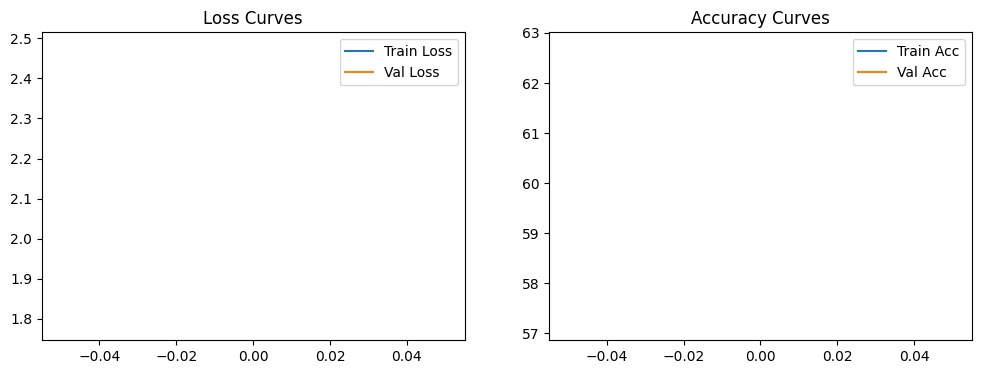

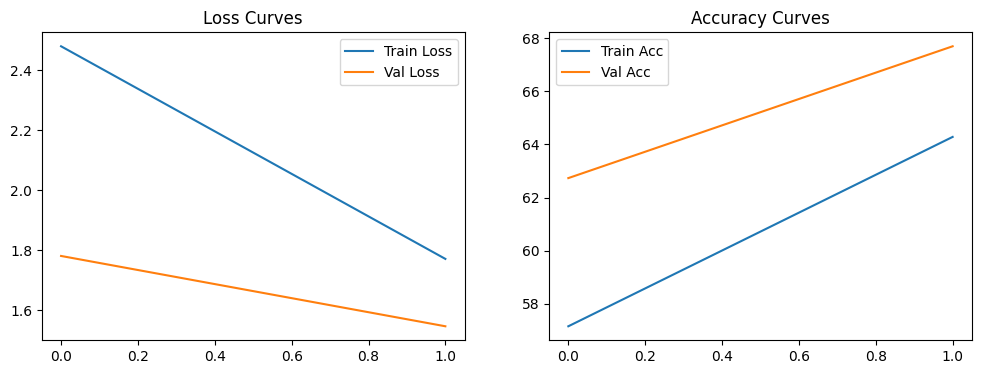

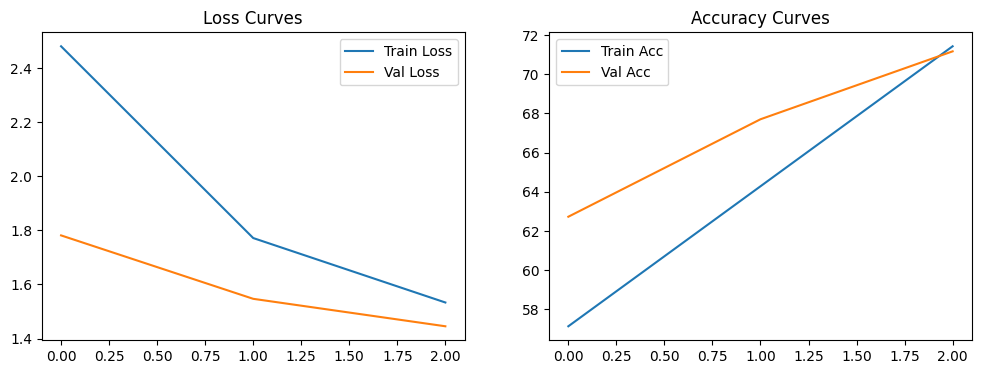

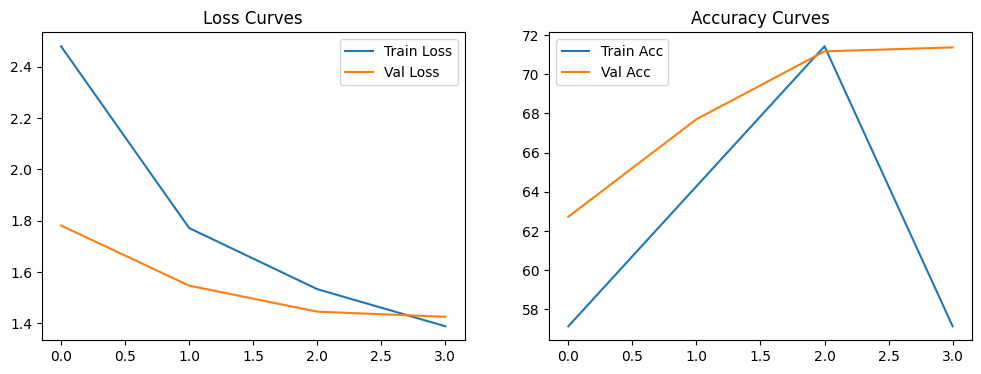

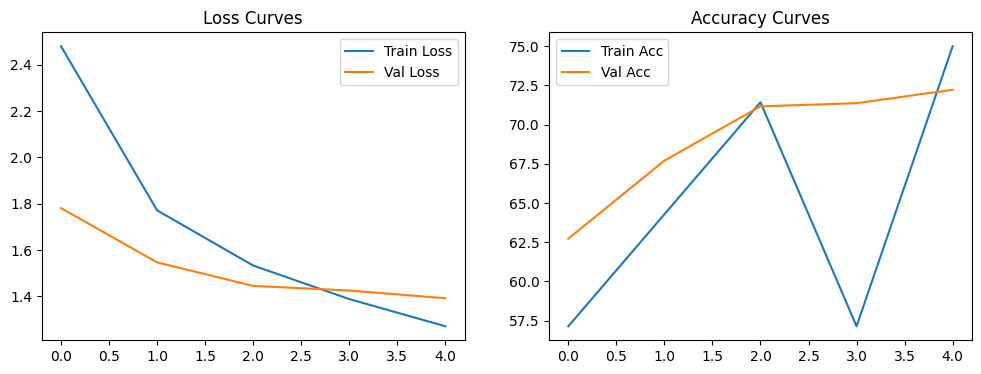

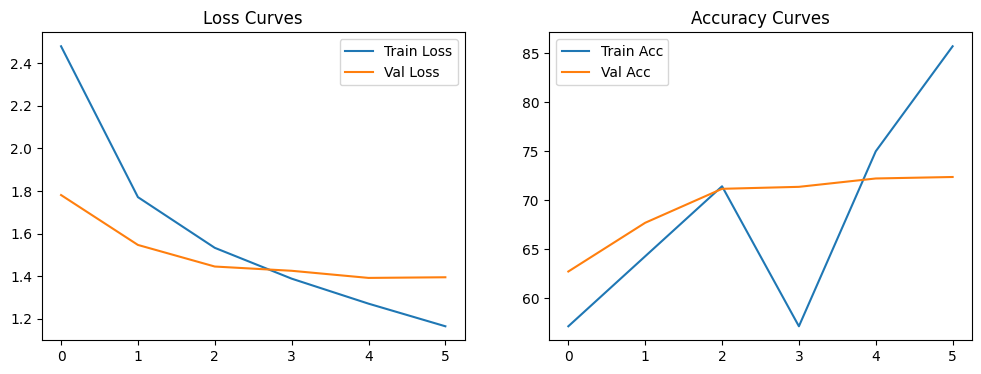

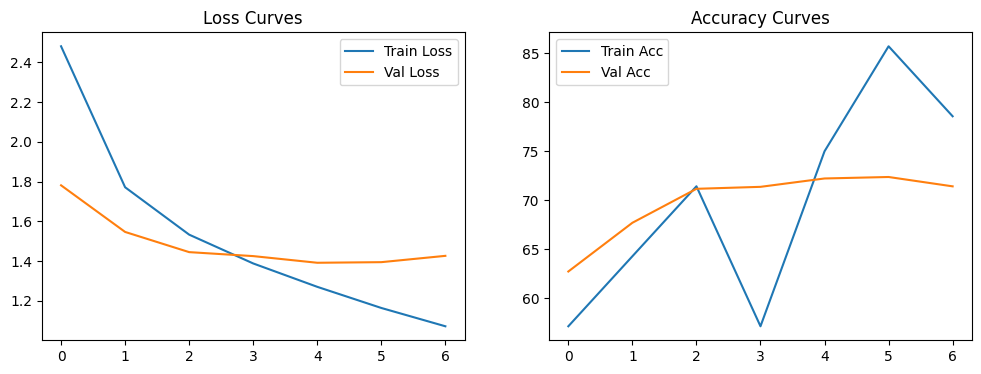

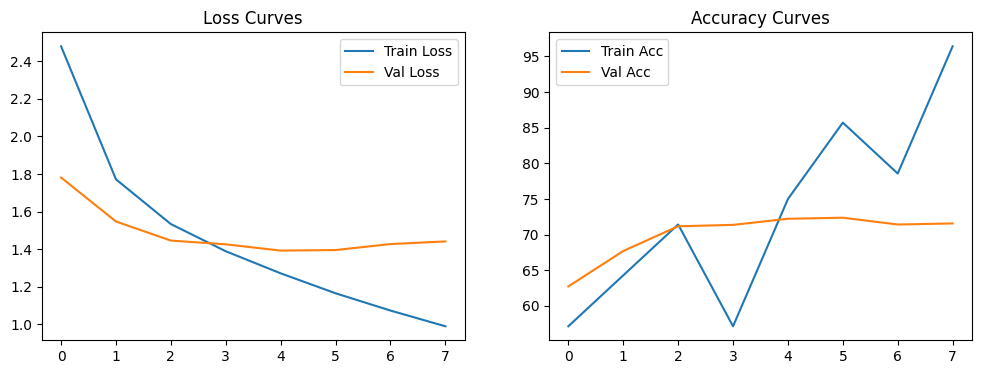

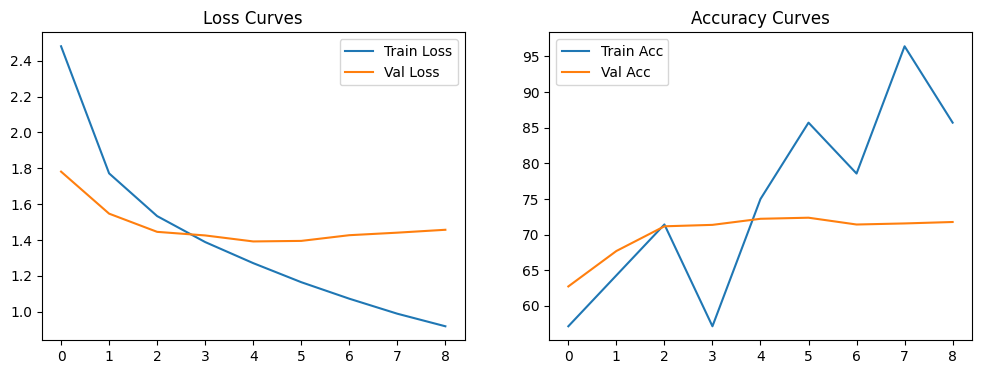

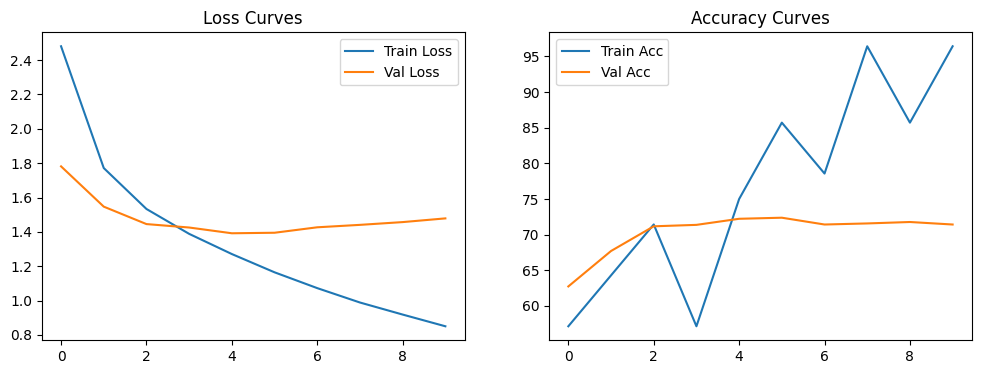

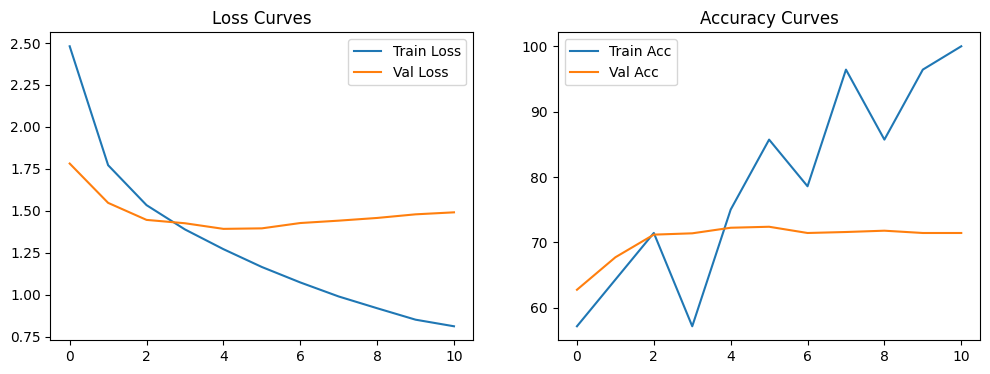

In [59]:
model, train_loader, val_loader, best_val_acc = train_model(num_epochs=20)
if model is not None:
    print(f"Training completed with best validation accuracy: {best_val_acc:.4f}")




In [60]:
model

BiLSTMAttentionBERT(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
#!cp /content/models/model_epoch8_acc72.53.pt /content/drive/MyDrive/

In [61]:
from torch.serialization import add_safe_globals

In [62]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [64]:
get_device()

device(type='cuda')

In [69]:
def load_model_for_prediction(model_path):

    device = get_device()

    try:
        # First try loading with weights_only
        checkpoint = torch.load(
            model_path,
            map_location=device,
            weights_only=True
        )
    except Exception as e:
        print(f"Warning: Failed to load with weights_only=True: {str(e)}")
        print("Attempting to load without weights_only...")
        checkpoint = torch.load(
            model_path,
            map_location=device,
            weights_only=False  # Fallback
        )

    try:
        # Initialize model
        model = BiLSTMAttentionBERT(
            hidden_dim=128,
            num_classes=22,
            num_layers=2,
            dropout=0.5
        ).to(device)

        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        # Initialize label encoder
        label_encoder = LabelEncoder()
        label_encoder.classes_ = np.array(checkpoint.get('label_encoder_classes',
                        ['Addition', 'Causal', 'Cause and Effect', 'Clarification', 'Comparison',
                         'Concession', 'Conditional', 'Contrast', 'Contrastive Emphasis',
                          'Definition', 'Elaboration', 'Emphasis', 'Enumeration', 'Explanation',
                          'Generalization', 'Illustration', 'Inference', 'Problem Solution', 'Purpose',
                          'Sequential', 'Summary', 'Temporal Sequence']))

        # Initialize tokenizer
        tokenizer = AutoTokenizer.from_pretrained(
            'dmis-lab/biobert-base-cased-v1.2',
            local_files_only=True
        )

        return model, label_encoder, tokenizer

    except Exception as e:
        print(f"Error initializing model components: {str(e)}")
        return None, None, None

In [70]:
def predict_sentence(model, sentence, tokenizer, label_encoder, device=None):
    """
    Make prediction for a single sentence with label validation.
    """
    device = get_device() if device is None else device
    model = model.to(device)
    model.eval()

    # Tokenize
    encoding = tokenizer(
        sentence,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)

    try:
        with torch.no_grad():
            # Get model outputs
            outputs = model(encoding['input_ids'], encoding['attention_mask'])
            probabilities = torch.softmax(outputs, dim=1)

            # Get prediction and probability
            prob, pred_idx = torch.max(probabilities, dim=1)

            # Validate prediction index
            if pred_idx.item() >= len(label_encoder.classes_):
                print(f"Warning: Model predicted invalid label index {pred_idx.item()}")
                return "Unknown", 0.0

            # Convert to label
            try:
                predicted_class = label_encoder.classes_[pred_idx.item()]
                return predicted_class, prob.item()
            except IndexError:
                print(f"Warning: Invalid label index {pred_idx.item()}")
                return "Unknown", 0.0

    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return "Error", 0.0



In [71]:
def print_labels(label_encoder, show_counts=False):
    """Print all labels and their corresponding indices"""
    print("\nAvailable labels:")
    print("-" * 40)
    for idx, label in enumerate(label_encoder.classes_):
        print(f"Index {idx}: {label}")
    print("-" * 40)
    print(f"Total number of classes: {len(label_encoder.classes_)}\n")

In [ ]:
model_path = '/content/models/model_epoch8_acc72.53.pt'
try:
    model, label_encoder, tokenizer = load_model_for_prediction(model_path)

    if all((model, label_encoder, tokenizer)):
        print_labels(label_encoder)
        df = pd.read_csv('/history_01.csv')
        for sentence in df['Sentence']:
            #sentence = "Across cultures and eras, common goals in medicine, such as curing illness and prolonging life, can be observed."
            label, confidence = predict_sentence(model, sentence, tokenizer, label_encoder)

            if label not in ("Unknown", "Error"):

                print(f"Predicted: {label} (confidence: {confidence:.2f})")
            else:
                print(f"Prediction failed: {label}")
except Exception as e:
    print(f"Error: {str(e)}")

	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.
Attempting to load without weights_only...

Available labels:
----------------------------------------
Index 0: Addition
Index 1: Causal
Index 2: Cause and Effect
Index 3: Clarification
Index 4: Comparison
Index 5: Concession
Index 6: Conditional
Index 7: Contrast
Index 8: Contrastive Emphasis